In [1]:
import sys

sys.path.append("/p/home/jusers/pierschke1/shared/HyperBrain")
sys.path.append("/p/home/jusers/pierschke1/shared/HyperBrain\\source")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [2]:
from source.datasets.brain_dataset import BrainDataset
from source.loftr.backbone import ResNetFPN_32_8, ResNetFPN_16_4, ResNetFPN_8_2
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.loftr.fine_preprocess import FinePreprocess
from source.loftr.loss import *
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import time
import torch
from torch import nn
from source.miscellaneous.evaluation import evaluate_model, read_model_evaluation_metrics
from einops.einops import rearrange
from source.miscellaneous.model_saving import save_model
from source.datasets.brain_dataset import collate_fn
from torch.optim.lr_scheduler import StepLR

In [3]:
crop_size = 1280
affine_transformation_range = 0.1
perspective_transformation_range = 0
patch_size = 32
max_translation_shift = 100
fine_height_width = (crop_size//patch_size)*4
coarse_height_width = crop_size//patch_size
images_directory = "../../data/cyto_downscaled_3344_3904/"
use_train_data = True
attention = "linear"

dataset_train = BrainDataset(
    images_directory=images_directory,
    train=use_train_data,
    affine_transformation_range=affine_transformation_range,
    perspective_transformation_range=perspective_transformation_range,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_height_width=fine_height_width,
    transform=v2.Compose([v2.Normalize(mean=[0.594], std=[0.204])]),
    load_in_gpu=True,
    sample_both_coordinates=True
)

In [4]:
batch_size = 4

dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=False,
    drop_last=False,
    collate_fn=collate_fn,
)

In [5]:
from source.visualization.image_visualization import plot_images_with_matches_via_match_matrix

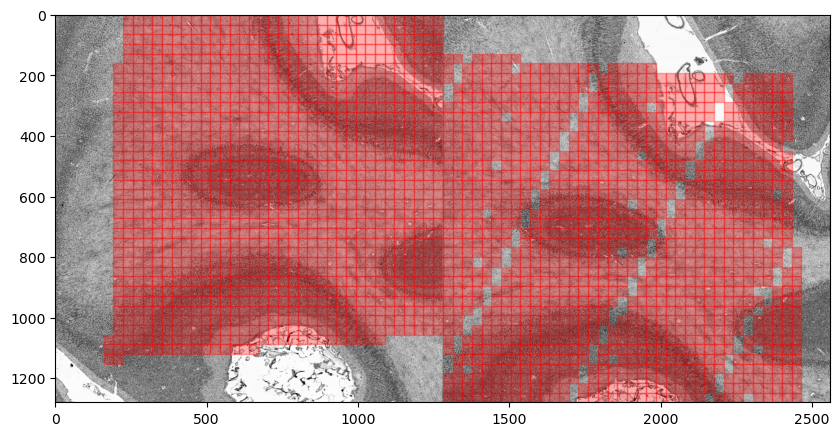

In [16]:
image_1_crop, image_2_crop, match_matrix, relative_coordinates, mapping = dataset_train[7]
plot_images_with_matches_via_match_matrix(image_1_crop.cpu(), image_2_crop.cpu(), 
                                          match_matrix, visualization_mode="patches",
                                          patch_size=32)

In [5]:
learning_rate = 0.001
weight_decay = 0.0015
use_coarse_context = False
use_l2_with_standard_deviation = False
temperature = (
    0.2  # Dont decrease this value, it will yield in overflows (similarity_matrix)
)

device = "cuda" if torch.cuda.is_available() else "cpu"
# block_dimensions_8_2 =
# block_dimensions_16_4 = [64, 96, 128, 192]
# block_dimensions_32_8 = [32, 64, 96, 128, 192]
block_dimensions = [32, 64, 96, 128, 192]
fine_feature_size = block_dimensions[2]  # 2 for 32_8, 1 for 16_4, 0 for 8_2
coarse_feature_size = block_dimensions[-1]
backbone = ResNetFPN_32_8(block_dimensions=block_dimensions).to(device=device)
backbone = nn.DataParallel(backbone)

positional_encoding = PositionalEncoding(coarse_feature_size).to(device=device)

coarse_loftr = LocalFeatureTransformer(
    feature_dimension=coarse_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"] * 4,
    attention_type=attention
).to(device=device)
coarse_loftr = nn.DataParallel(coarse_loftr)


coarse_matcher = CoarseMatching(temperature=temperature, confidence_threshold=0.2).to(
    device=device
)

fine_preprocess = FinePreprocess(
    coarse_feature_size=coarse_feature_size,
    fine_feature_size=fine_feature_size,
    window_size=5,
    use_coarse_context=use_coarse_context,
).to(device=device)
fine_loftr = LocalFeatureTransformer(
    feature_dimension=fine_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"],
    attention_type=attention
).to(device=device)
# fine_loftr = nn.DataParallel(coarse_loftr)


fine_matching = FineMatching(
    return_standard_deviation=use_l2_with_standard_deviation,
).to(device=device)

params = list(backbone.parameters()) + list(coarse_loftr.parameters()) + list(fine_loftr.parameters())
optimizer = torch.optim.Adam(params, weight_decay=weight_decay, lr=learning_rate)

learning_rate_gamma = 0.85
learning_rate_step_size = 80
scheduler = StepLR(optimizer, step_size=learning_rate_step_size, gamma=learning_rate_gamma)

coarse_loss_history = []
fine_loss_history = []
loss_hist_test = []

In [6]:
coarse_loss = "official_focal"
alpha = 0.45
gamma = 2
fine_loss = "l2_std" if use_l2_with_standard_deviation else "l2"

In [7]:
seen_datapoints = 0

In [8]:
training_run = "coarse_matching"
model_directory = "../../models"

In [ ]:
epochs = 500

for epoch in range(1, epochs+1):
    epoch_start_time = time.time()
    
    for step, batch in enumerate(dataloader_train):
        image_1_crop, image_2_crop, match_matrix, relative_coordinates, _ = batch
        number_of_matches = match_matrix.sum()
        # print(number_of_matches)

        seen_datapoints += image_1_crop.shape[0]
        
        image_1_crop = image_1_crop.to(device=device)
        image_2_crop = image_2_crop.to(device=device)
        match_matrix = match_matrix.to(device=device)
        relative_coordinates = relative_coordinates.to(device=device)

        coarse_image_feature_1, fine_image_feature_1 = backbone(image_1_crop)
        coarse_image_feature_2, fine_image_feature_2 = backbone(image_2_crop)
        
        coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
        coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

        coarse_image_feature_1 = rearrange(
            coarse_image_feature_1, "n c h w -> n (h w) c"
        )
        coarse_image_feature_2 = rearrange(
            coarse_image_feature_2, "n c h w -> n (h w) c"
        )

        coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(
            coarse_image_feature_1, coarse_image_feature_2
        )

        coarse_matches = coarse_matcher(coarse_image_feature_1, coarse_image_feature_2)

        coarse_matches_ground_truth = {
            "batch_indices": match_matrix.nonzero()[:, 0],
            "row_indices": match_matrix.nonzero()[:, 1],
            "column_indices": match_matrix.nonzero()[:, 2],
        }
        
        if number_of_matches!=0:  #TODO double check if always same number of matches in batch
            
            fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_preprocess(
                coarse_image_feature_1=coarse_image_feature_1,
                coarse_image_feature_2=coarse_image_feature_2,
                fine_image_feature_1=fine_image_feature_1,
                fine_image_feature_2=fine_image_feature_2,
                coarse_matches=coarse_matches_ground_truth,
                fine_height_width=fine_height_width,
                coarse_height_width=coarse_height_width,
            )

            fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_loftr(
                fine_image_feature_1_unfold, fine_image_feature_2_unfold
            )

            predicted_relative_coordinates = fine_matching(
                fine_image_feature_1_unfold, fine_image_feature_2_unfold
            )

        if coarse_loss == "focal":
            coarse_loss_value = coarse_focal_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix,
                alpha=alpha,
                gamma=gamma,
            )

        elif coarse_loss == "official_focal":
            coarse_loss_value = coarse_official_focal_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix,
                alpha=alpha,
                gamma=gamma,
            )

        elif coarse_loss == "cross_entropy":
            coarse_loss_value = coarse_cross_entropy_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix,
            )

        if fine_loss == "l2" and number_of_matches != 0:
            fine_loss_value = fine_l2_loss(
                coordinates_predicted=predicted_relative_coordinates,
                coordinates_ground_truth=relative_coordinates,
            )

        elif fine_loss == "l2_std" and number_of_matches != 0:
            fine_loss_value = fine_l2_loss_with_standard_deviation(
                coordinates_predicted=predicted_relative_coordinates,
                coordinates_ground_truth=relative_coordinates,
            )

        loss = coarse_loss_value + fine_loss_value if number_of_matches != 0 else coarse_loss_value
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        epoch_duration = time.time() - epoch_start_time

        optimizer.zero_grad()

        coarse_loss_history.append(coarse_loss_value.cpu().item())
        fine_loss_history.append(fine_loss_value.cpu().item())
    
    if epoch % 10 ==1:
        print(f"Epoch: {epoch}, Seen Datapoints: {seen_datapoints}, Duration: {epoch_duration:.2f} sec, Coarse Loss: {coarse_loss_value:.4f}, Fine Loss: {fine_loss_value:.4f}")

    if epoch % 20 == 1 and epoch > 1:
        hyperparameters = {
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "coarse_context": use_coarse_context,
        "img_size": "3344_3904",
        "ResNet": backbone.__class__.__name__,
        "affine_transformation_range": affine_transformation_range,
        "perspective_transformation_range": perspective_transformation_range,
        "temperature": temperature,
        "batch_size": batch_size,
        "coarse_loss": coarse_loss,
        "fine_loss": fine_loss,
        "use_train_data": use_train_data,
        "block_dimensions": block_dimensions,
        "use_l2_with_standard_deviation": use_l2_with_standard_deviation,
        "seen_datapoints": seen_datapoints,
        "crop_size": crop_size,
        "patch_size": patch_size
        }

        if coarse_loss == "focal":
            hyperparameters["gamma"] = gamma
            hyperparameters["alpha"] = alpha

        if scheduler:
            hyperparameters["scheduler"] = scheduler.__class__.__name__
            hyperparameters["learning_rate_gamma"] = learning_rate_gamma
            hyperparameters["learning_rate_step_size"] = learning_rate_step_size
        
        models = {"backbone": backbone, "coarse_loftr": coarse_loftr, "fine_loftr": fine_loftr}
        model_directory = save_model(
            models,
            hyperparameters=hyperparameters,
            coarse_loss_history=coarse_loss_history,
            fine_loss_history=fine_loss_history,
            base_path=f"../../models/{training_run}"
        )

Epoch: 1, Seen Datapoints: 288, Duration: 2.18 sec, Coarse Loss: 1.9375, Fine Loss: 0.3794
Epoch: 11, Seen Datapoints: 368, Duration: 1.97 sec, Coarse Loss: 1.8783, Fine Loss: 0.3038
Epoch: 21, Seen Datapoints: 448, Duration: 2.04 sec, Coarse Loss: 1.4294, Fine Loss: 0.3347
Epoch: 31, Seen Datapoints: 528, Duration: 2.02 sec, Coarse Loss: 1.2238, Fine Loss: 0.2163
Epoch: 41, Seen Datapoints: 608, Duration: 2.12 sec, Coarse Loss: 1.2034, Fine Loss: 0.2426
Epoch: 51, Seen Datapoints: 688, Duration: 2.11 sec, Coarse Loss: 0.8069, Fine Loss: 0.1988
Epoch: 61, Seen Datapoints: 768, Duration: 1.98 sec, Coarse Loss: 0.7650, Fine Loss: 0.1851
Epoch: 71, Seen Datapoints: 848, Duration: 2.01 sec, Coarse Loss: 1.6077, Fine Loss: 0.3235
Epoch: 81, Seen Datapoints: 928, Duration: 1.98 sec, Coarse Loss: 0.7946, Fine Loss: 0.1784
Epoch: 91, Seen Datapoints: 1008, Duration: 2.01 sec, Coarse Loss: 0.8234, Fine Loss: 0.1748
Epoch: 101, Seen Datapoints: 1088, Duration: 2.04 sec, Coarse Loss: 0.6622, Fine